# Adding Scale Bars to Microscopy Images

This notebook demonstrates how to add publication-quality scale bars to microscopy images
from the VarChAMP dataset. Scale bars are added post-hoc as matplotlib overlays, without
modifying the underlying image data or existing visualization functions.

## Microscope Specifications
- **Microscope**: Perkin Elmer Phenix
- **Objective**: 20x magnification
- **Binning**: 2×2
- **Pixel Size**: **0.598 µm/pixel** (verified from Index.idx.xml metadata)

## Image Types
- **Well-level images**: 1080×1080 pixels (~645 µm × 645 µm)
- **Cell-level images**: 128×128 pixels (~76 µm × 76 µm) or 96×96 pixels (~57 µm × 57 µm)

## 1. Setup and Imports

In [1]:
import sys
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm
import matplotlib as mpl

# Force TrueType font embedding (Type 42)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

font_path = "../../../../utils/ARIAL.TTF"
fm.fontManager.addfont(font_path)

font_prop = fm.FontProperties(fname=font_path)
# Set font family to one of the accepted fonts
plt.rcParams.update({
    "font.family": font_prop.get_name(),
    "font.sans-serif": ["ARIAL"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

# Add paths for visualization modules
sys.path.insert(1, "../1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/scripts/cell_img_visualization")
sys.path.insert(1, "../1_snakemake_pipeline/2025_varchamp_snakemake")

# Import scale bar utilities
from scalebar_utils import (
    add_scale_bar,
    calculate_optimal_scale_bar_length,
    add_scale_bar_to_axes_list,
    VARCHAMP_PIXEL_SIZE_UM
)

# Import existing visualization functions
from cell_selector import (
    filter_cells_by_metadata,
    filter_by_quality_metrics,
    select_cells_percentile_random,
    compute_distance_to_edge
)
from cell_cropper import load_multichannel_cell_crops
from cell_visualizer import (
    viz_cell_single_channel,
    viz_cell_multi_channel,
    viz_cell_grid
)
from img_utils import TIFF_IMGS_DIR

print(f"VarChAMP Pixel Size: {VARCHAMP_PIXEL_SIZE_UM} µm/pixel")
print(f"\nScale bar calculations:")
print(f"  10 µm bar = {10 / VARCHAMP_PIXEL_SIZE_UM:.2f} pixels")
print(f"  100 µm bar = {100 / VARCHAMP_PIXEL_SIZE_UM:.2f} pixels")

VarChAMP Pixel Size: 0.598 µm/pixel

Scale bar calculations:
  10 µm bar = 16.72 pixels
  100 µm bar = 167.22 pixels


## 2. Load Example Data

Load cell profiles and filter to get example cells for visualization.

In [2]:
# Load cell profiles
profiles_filtered = pl.scan_parquet(
    "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_var_mad_all_feats_filtered_cells.parquet"
).filter(
    pl.col("Metadata_gene_allele").str.contains("F9")
).collect()

# Add distance to edge column for quality filtering
profiles_filtered = profiles_filtered.with_columns(compute_distance_to_edge().alias("dist2edge"))

In [3]:
profiles = pl.scan_parquet(
    "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_prof_filtered_metadata.parquet"
).filter(
    pl.col("Metadata_gene_allele").str.contains("F9")
).collect()
profiles = profiles.with_columns(compute_distance_to_edge().alias("dist2edge"))

profiles = profiles.join(
    profiles_filtered.select(["Metadata_CellID"]+[
        c for c in profiles_filtered.columns if c not in profiles.columns
    ]),
    on="Metadata_CellID"
)

In [4]:
f9_var_profiles = {
    "F9_Cys28Arg": filter_by_quality_metrics(filter_cells_by_metadata(profiles, allele='F9_Cys28Arg'), min_edge_dist=50),
    "F9_Ile316Thr": filter_by_quality_metrics(filter_cells_by_metadata(profiles, allele='F9_Ile316Thr'), min_edge_dist=50),
    "F9": filter_by_quality_metrics(filter_cells_by_metadata(profiles, allele='F9'), min_edge_dist=50),
}

example_cys28_cells = select_cells_percentile_random(
    f9_var_profiles["F9_Cys28Arg"],
    feature="Nuclei_Correlation_K_GFP_Mito", ## Nuclei_Correlation_K_GFP_Mito | (50, 75)
    percentile_bins=[(50, 75)],
    n_per_bin=50,
    seed=42
)

example_cys28_cells_cyto = select_cells_percentile_random(
    f9_var_profiles["F9_Cys28Arg"],
    feature="Cytoplasm_Texture_Entropy_GFP_10_00_256", ## Nuclei_Correlation_K_GFP_Mito | (50, 75)
    percentile_bins=[(25, 50)],
    n_per_bin=50,
    seed=42
).sort("Cytoplasm_Texture_Entropy_GFP_10_00_256", descending=False)

example_ile316_cells = select_cells_percentile_random(
    f9_var_profiles["F9_Ile316Thr"],
    feature="Cytoplasm_Texture_Entropy_GFP_10_00_256",
    percentile_bins=[(50, 75)],
    n_per_bin=50,
    seed=42
)
example_ref_cells = select_cells_percentile_random(
    f9_var_profiles["F9"],
    feature="Cytoplasm_Texture_Entropy_GFP_10_00_256", ## Cytoplasm_Texture_Entropy_GFP_10_00_256, Nuclei_Correlation_K_GFP_Mito
    percentile_bins=[(25, 50)],
    n_per_bin=50,
    seed=42
)

# print(f"Selected {len(example_var_cells)} variant cells")
# print(f"Selected {len(example_ref_cells)} reference cells")

In [66]:
# example_cys28_cells["Cytoplasm_Texture_Entropy_GFP_10_00_256"].describe()
# example_ref_cells["Cytoplasm_Texture_Entropy_GFP_10_00_256"].describe()
# example_ile316_cells#["Cytoplasm_Texture_Entropy_GFP_10_00_256"].describe()

## 3. Example 1: Single Cell, Single Channel with Scale Bar

The simplest use case: add a 10 µm scale bar to a single cell image.

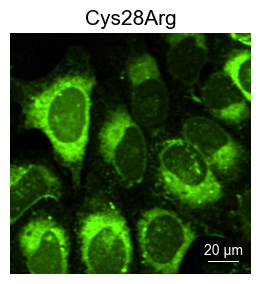

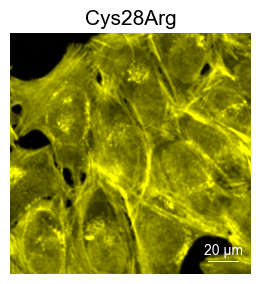

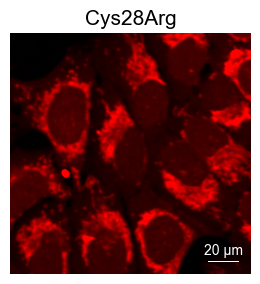

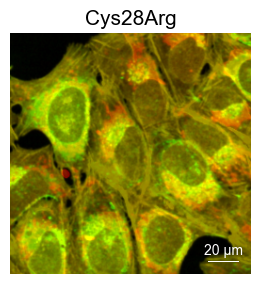

In [ ]:
# Load cell crops for one cell
def plot_single_cell_crop(allele, cell_crop, channels, idx=0):
    # channels = ['GFP']
    cell_crops = load_multichannel_cell_crops(
        cell_crop,
        channels,
        imgs_dir=TIFF_IMGS_DIR,
        method='fixed',
        crop_size=256
    )

    # Create figure and display image using existing function
    fig, ax = plt.subplots(figsize=(3, 3))
    if len(channels)== 1:
        viz_cell_single_channel(
            cell_crops[channels[0]],
            channel=channels[0],
            ax=ax,
            axis_off=True,
            percentile_low=1.0,
            percentile_high=99.0,
            title=""
        )
    else:
        viz_cell_multi_channel(
            cell_crops,
            channels=channels,
            channel_mapping='gfp_inclusive',
            contrast_percentiles=95,
            ax=ax,
            axis_off=True,
            title=''
        )
    ax.set_title(allele, fontsize=15)
    # Add 10 µm scale bar post-hoc
    add_scale_bar(
        ax,
        pixel_size_um=VARCHAMP_PIXEL_SIZE_UM,
        image_width_pixels=256,
        scale_bar_length_um=20,
        location='lower right',
        color='white',
        fontsize=10
    )
    plt.tight_layout()
    plt.savefig(f"../../3_outputs/2_results_summary/F9/{allele}-{idx}_{'-'.join(channels)}_cell_crop.svg", dpi=400, transparent=True, bbox_inches='tight')
    plt.show()

# plot_single_cell_crop("Cys28Arg", example_cys28_cells_cyto[47], channels=["GFP"])
# plot_single_cell_crop("Cys28Arg", example_cys28_cells_cyto[47], channels=["AGP"])
# plot_single_cell_crop("Cys28Arg", example_cys28_cells_cyto[47], channels=["Mito"])
# plot_single_cell_crop("Cys28Arg", example_cys28_cells_cyto[47], channels=["GFP","Mito","AGP"])

plot_single_cell_crop("Cys28Arg", example_cys28_cells[47], channels=["GFP"])
plot_single_cell_crop("Cys28Arg", example_cys28_cells[47], channels=["AGP"])
plot_single_cell_crop("Cys28Arg", example_cys28_cells[47], channels=["Mito"])
plot_single_cell_crop("Cys28Arg", example_cys28_cells[47], channels=["GFP","Mito","AGP"])

# plot_single_cell_crop("Ile316Thr", example_ile316_cells[11], channels=["GFP"])
# plot_single_cell_crop("Ile316Thr", example_ile316_cells[11], channels=["AGP"])
# plot_single_cell_crop("Ile316Thr", example_ile316_cells[11], channels=["Mito"])
# plot_single_cell_crop("Ile316Thr", example_ile316_cells[11], channels=["GFP","Mito","AGP"])

# plot_single_cell_crop("F9", example_ref_cells[11], channels=["GFP"])
# plot_single_cell_crop("F9", example_ref_cells[11], channels=["AGP"])
# plot_single_cell_crop("F9", example_ref_cells[11], channels=["Mito"])
# plot_single_cell_crop("F9", example_ref_cells[11], channels=["GFP","Mito","AGP"])

# print("\nScale bar added to lower right corner")
# print(f"Scale bar length: {10 / VARCHAMP_PIXEL_SIZE_UM:.1f} pixels")

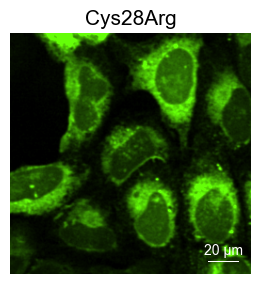

In [69]:
plot_single_cell_crop("Cys28Arg", example_cys28_cells[14], channels=["GFP"], idx=1)
# plot_single_cell_crop("Ile316Thr", example_ile316_cells[10], idx=1)
# plot_single_cell_crop("F9", example_ref_cells[35], idx=1)

In [ ]:
# Load cell crops for one cell
channels = ['GFP']
cell_crops = load_multichannel_cell_crops(
    f9_var_profiles["F9"][50],
    channels,
    imgs_dir=TIFF_IMGS_DIR,
    method='fixed',
    crop_size=128
)

# Create figure and display image using existing function
fig, ax = plt.subplots(figsize=(3, 3))
viz_cell_single_channel(
    cell_crops['GFP'],
    channel='GFP',
    ax=ax,
    axis_off=True,
    percentile_low=1.0,
    percentile_high=99.0,
    title='F9'
)

# Add 10 µm scale bar post-hoc
add_scale_bar(
    ax,
    pixel_size_um=VARCHAMP_PIXEL_SIZE_UM,
    image_width_pixels=128,
    scale_bar_length_um=10,
    location='lower right',
    color='white',
    fontsize=10
)

plt.tight_layout()
plt.show()

print("\nScale bar added to lower right corner")
print(f"Scale bar length: {10 / VARCHAMP_PIXEL_SIZE_UM:.1f} pixels")

NameError: name 'f9_var_profiles' is not defined

## 4. Example 2: Multiple Cells in Grid Layout

Add scale bars to multiple cell images displayed in a grid.

In [3]:
# # Create grid of 5 variant cells
# n_cells = 5
# channels = ['GFP']

# fig, axes = plt.subplots(1, n_cells, figsize=(n_cells*3, 3))

# for i in range(n_cells):
#     # Load and display each cell
#     cell_crops = load_multichannel_cell_crops(
#         example_var_cells[i],
#         channels,
#         imgs_dir=TIFF_IMGS_DIR,
#         method='fixed',
#         crop_size=128
#     )
    
#     viz_cell_single_channel(
#         cell_crops['GFP'],
#         channel='GFP',
#         ax=axes[i],
#         axis_off=True,
#         percentile_low=1.0,
#         percentile_high=99.0,
#         title=f'Cell {i+1}'
#     )
    
#     # Add scale bar to each cell
#     add_scale_bar(
#         axes[i],
#         pixel_size_um=VARCHAMP_PIXEL_SIZE_UM,
#         image_width_pixels=128,
#         scale_bar_length_um=10,
#         location='lower right'
#     )

# plt.tight_layout()
# plt.show()

# print(f"Added 10 µm scale bars to {n_cells} cells")

## 5. Example 3: Multi-Channel Visualization with Scale Bars

Add scale bars to multi-channel cell visualization (DAPI, AGP, Mito, GFP).

In [4]:
# # Load all channels for one cell
# channels = ['DAPI', 'AGP', 'Mito', 'GFP']
# cell_crops = load_multichannel_cell_crops(
#     example_var_cells[0],
#     channels,
#     imgs_dir=TIFF_IMGS_DIR,
#     method='fixed',
#     crop_size=128
# )

# # Create grid: 4 individual channels + 1 RGB merged
# n_channels = len(channels)
# fig, axes = plt.subplots(1, n_channels + 1, figsize=(18, 3))

# # Display individual channels
# for i, channel in enumerate(channels):
#     viz_cell_single_channel(
#         cell_crops[channel],
#         channel=channel,
#         ax=axes[i],
#         axis_off=True,
#         percentile_low=1,
#         percentile_high=99,
#         title=channel
#     )
    
#     # Add scale bar to each channel
#     add_scale_bar(
#         axes[i],
#         pixel_size_um=VARCHAMP_PIXEL_SIZE_UM,
#         image_width_pixels=128,
#         scale_bar_length_um=10
#     )

# # Display RGB merged
# viz_cell_multi_channel(
#     cell_crops,
#     channels=channels,
#     channel_mapping='gfp_inclusive',
#     contrast_percentiles=95,
#     ax=axes[-1],
#     axis_off=True,
#     title='RGB Merged'
# )

# # Add scale bar to merged image
# add_scale_bar(
#     axes[-1],
#     pixel_size_um=VARCHAMP_PIXEL_SIZE_UM,
#     image_width_pixels=128,
#     scale_bar_length_um=10
# )

# plt.tight_layout()
# plt.show()

# print(f"Added scale bars to all {n_channels} channels plus RGB merged image")

## 6. Example 4: Variant vs Reference Comparison

Compare variant and reference cells with scale bars.

In [2]:
# # Load crops for variant and reference cells
# channels = ['GFP']
# n_cells = 5

# fig, axes = plt.subplots(2, n_cells, figsize=(n_cells*3, 6))

# # Row 0: Variant cells
# for i in range(n_cells):
#     var_crops = load_multichannel_cell_crops(
#         example_var_cells[i],
#         channels,
#         imgs_dir=TIFF_IMGS_DIR,
#         method='fixed',
#         crop_size=128
#     )
    
#     viz_cell_single_channel(
#         var_crops['GFP'],
#         channel='GFP',
#         ax=axes[0, i],
#         axis_off=True,
#         percentile_low=1.0,
#         percentile_high=99.0,
#         title=f'V{i+1}' if i % 3 == 0 else None
#     )
    
#     add_scale_bar(axes[0, i], VARCHAMP_PIXEL_SIZE_UM, 128, 10)

# # Row 1: Reference cells
# for i in range(n_cells):
#     ref_crops = load_multichannel_cell_crops(
#         example_ref_cells[i],
#         channels,
#         imgs_dir=TIFF_IMGS_DIR,
#         method='fixed',
#         crop_size=128
#     )
    
#     viz_cell_single_channel(
#         ref_crops['GFP'],
#         channel='GFP',
#         ax=axes[1, i],
#         axis_off=True,
#         percentile_low=1.0,
#         percentile_high=99.0,
#         title=f'R{i+1}' if i % 3 == 0 else None
#     )
    
#     add_scale_bar(axes[1, i], VARCHAMP_PIXEL_SIZE_UM, 128, 10)

# # Add row labels
# axes[0, 0].text(-0.15, 0.5, 'F9_Cys28Arg\n(Variant)',
#                 transform=axes[0, 0].transAxes,
#                 fontsize=12, fontweight='bold',
#                 rotation=90, va='center', ha='right')

# axes[1, 0].text(-0.15, 0.5, 'F9\n(Reference)',
#                 transform=axes[1, 0].transAxes,
#                 fontsize=12, fontweight='bold',
#                 rotation=90, va='center', ha='right')

# plt.tight_layout()
# plt.subplots_adjust(wspace=0)
# plt.show()

# print(f"Variant vs Reference comparison with {n_cells} cells each")

## 7. Example 5: Different Scale Bar Positions

Demonstrate all four corner positions for scale bars.

In [ ]:
# Load one cell
channels = ['GFP']
cell_crops = load_multichannel_cell_crops(
    example_var_cells[0],
    channels,
    imgs_dir=TIFF_IMGS_DIR,
    method='fixed',
    crop_size=128
)

# Create grid showing all four positions
positions = ['lower right', 'lower left', 'upper right', 'upper left']
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, position in enumerate(positions):
    viz_cell_single_channel(
        cell_crops['GFP'],
        channel='GFP',
        ax=axes[i],
        axis_off=True,
        percentile_low=1.0,
        percentile_high=99.0,
        title=position.replace('_', ' ').title()
    )
    
    add_scale_bar(
        axes[i],
        pixel_size_um=VARCHAMP_PIXEL_SIZE_UM,
        image_width_pixels=128,
        scale_bar_length_um=10,
        location=position
    )

plt.tight_layout()
plt.show()

print("Scale bar positions demonstrated: lower right (default), lower left, upper right, upper left")

## 8. Example 6: Custom Scale Bar Styling

Demonstrate different colors and font sizes.

In [ ]:
# Load one cell
channels = ['GFP']
cell_crops = load_multichannel_cell_crops(
    example_var_cells[0],
    channels,
    imgs_dir=TIFF_IMGS_DIR,
    method='fixed',
    crop_size=128
)

# Create grid showing different styles
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Style 1: Default white
viz_cell_single_channel(
    cell_crops['GFP'], 'GFP', ax=axes[0], axis_off=True,
    percentile_low=1.0, percentile_high=99.0, title='White (Default)'
)
add_scale_bar(axes[0], VARCHAMP_PIXEL_SIZE_UM, 128, 10, color='white', fontsize=10)

# Style 2: Yellow with larger font
viz_cell_single_channel(
    cell_crops['GFP'], 'GFP', ax=axes[1], axis_off=True,
    percentile_low=1.0, percentile_high=99.0, title='Yellow, Larger Font'
)
add_scale_bar(axes[1], VARCHAMP_PIXEL_SIZE_UM, 128, 10, color='yellow', fontsize=14)

# Style 3: Cyan with smaller font
viz_cell_single_channel(
    cell_crops['GFP'], 'GFP', ax=axes[2], axis_off=True,
    percentile_low=1.0, percentile_high=99.0, title='Cyan, Smaller Font'
)
add_scale_bar(axes[2], VARCHAMP_PIXEL_SIZE_UM, 128, 10, color='cyan', fontsize=8)

plt.tight_layout()
plt.show()

print("Different scale bar styles demonstrated")

## 9. Example 7: Using Batch Helper Function

Use `add_scale_bar_to_axes_list()` to add scale bars to multiple axes at once.

In [ ]:
# Create grid of cells
n_cells = 6
channels = ['GFP']

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Display cells without scale bars first
for i in range(n_cells):
    row = i // 3
    col = i % 3
    
    cell_crops = load_multichannel_cell_crops(
        example_var_cells[i] if row == 0 else example_ref_cells[i % 3],
        channels,
        imgs_dir=TIFF_IMGS_DIR,
        method='fixed',
        crop_size=128
    )
    
    viz_cell_single_channel(
        cell_crops['GFP'],
        channel='GFP',
        ax=axes[row, col],
        axis_off=True,
        percentile_low=1.0,
        percentile_high=99.0
    )

# Add scale bars to ALL axes at once using batch helper
add_scale_bar_to_axes_list(
    axes,
    pixel_size_um=VARCHAMP_PIXEL_SIZE_UM,
    image_width_pixels=128,
    scale_bar_length_um=10,
    location='lower right'
)

plt.tight_layout()
plt.show()

print(f"Added scale bars to all {n_cells} cells using batch helper function")

## 10. Example 8: Automatic Scale Bar Sizing

Use `calculate_optimal_scale_bar_length()` to automatically choose appropriate scale bar lengths.

In [ ]:
# Demonstrate optimal scale bar calculation for different image sizes
image_sizes = [96, 128, 256, 512, 1080]

print("Optimal scale bar lengths for different image sizes:")
print("=" * 60)
for size in image_sizes:
    optimal = calculate_optimal_scale_bar_length(size, VARCHAMP_PIXEL_SIZE_UM)
    image_width_um = size * VARCHAMP_PIXEL_SIZE_UM
    bar_pixels = optimal / VARCHAMP_PIXEL_SIZE_UM
    fraction = optimal / image_width_um
    
    print(f"  {size}×{size} pixels ({image_width_um:.1f} µm):")
    print(f"    Optimal scale bar: {optimal:.0f} µm ({bar_pixels:.1f} pixels, {fraction*100:.1f}% of width)")
    print()

# Visualize with automatically calculated scale bar
channels = ['GFP']
cell_crops = load_multichannel_cell_crops(
    example_var_cells[0],
    channels,
    imgs_dir=TIFF_IMGS_DIR,
    method='fixed',
    crop_size=128
)

fig, ax = plt.subplots(figsize=(6, 6))
viz_cell_single_channel(
    cell_crops['GFP'], 'GFP', ax=ax, axis_off=True,
    percentile_low=1.0, percentile_high=99.0,
    title='Auto-Sized Scale Bar'
)

# Calculate and add optimal scale bar
optimal_length = calculate_optimal_scale_bar_length(128, VARCHAMP_PIXEL_SIZE_UM)
add_scale_bar(ax, VARCHAMP_PIXEL_SIZE_UM, 128, scale_bar_length_um=optimal_length)

plt.tight_layout()
plt.show()

print(f"\nAdded automatically calculated {optimal_length:.0f} µm scale bar")

## 11. Integration with Existing Workflows

Examples of how to integrate scale bars into existing analysis notebooks.

### Integration Example 1: Adding to viz_cell_grid()

The `viz_cell_grid()` function creates complex multi-channel layouts. Add scale bars after calling it.

In [ ]:
# Load multi-channel crops
channels = ['DAPI', 'AGP', 'Mito', 'GFP']
cell_crops = load_multichannel_cell_crops(
    example_var_cells[0],
    channels,
    imgs_dir=TIFF_IMGS_DIR,
    method='fixed',
    crop_size=128
)

# Use existing viz_cell_grid function
fig = viz_cell_grid(
    cell_crops,
    channels=channels,
    include_merged=True,
    contrast_percentile=95
)

# Add scale bars to all axes in the grid
for ax in fig.get_axes():
    if len(ax.get_images()) > 0:  # Only add to axes with images
        add_scale_bar(
            ax,
            pixel_size_um=VARCHAMP_PIXEL_SIZE_UM,
            image_width_pixels=128,
            scale_bar_length_um=10
        )

plt.show()
print("Added scale bars to viz_cell_grid() output")

### Integration Example 2: Saving Publication-Quality Figures

Create figures with scale bars for publication.

In [1]:
# # Create publication-quality figure
# channels = ['GFP']
# n_cells = 5

# fig, axes = plt.subplots(1, n_cells, figsize=(15, 3), dpi=300)

# for i in range(n_cells):
#     cell_crops = load_multichannel_cell_crops(
#         example_var_cells[i],
#         channels,
#         imgs_dir=TIFF_IMGS_DIR,
#         method='fixed',
#         crop_size=128
#     )
    
#     viz_cell_single_channel(
#         cell_crops['GFP'], 'GFP', ax=axes[i], axis_off=True,
#         percentile_low=1.0, percentile_high=99.0
#     )
    
#     add_scale_bar(axes[i], VARCHAMP_PIXEL_SIZE_UM, 128, 10)

# plt.tight_layout()

# # Save with high DPI for publication
# output_path = 'f9_cells_with_scalebars.png'
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
# print(f"Saved publication-quality figure to {output_path}")

# plt.show()

## Summary

### Key Functions

1. **`add_scale_bar(ax, pixel_size_um, image_width_pixels, scale_bar_length_um, ...)`**
   - Core function to add scale bar to any matplotlib axes
   - Works with images displayed using `imshow()`
   - Supports 4 corner positions
   - Customizable color, font size, and dimensions

2. **`calculate_optimal_scale_bar_length(image_width_pixels, pixel_size_um)`**
   - Automatically suggests appropriate scale bar length
   - Returns standard values (1, 2, 5, 10, 20, 50, 100 µm)
   - Aims for ~20% of image width

3. **`add_scale_bar_to_axes_list(axes, pixel_size_um, image_width_pixels, ...)`**
   - Batch processing for multiple axes
   - Works with 1D lists or 2D arrays from `plt.subplots()`
   - Skips axes without images

### Best Practices

- **Cell-level images (128×128)**: Use 10 µm scale bars
- **Well-level images (1080×1080)**: Use 100 µm scale bars  
- **Position**: Lower right (default) is standard in microscopy
- **Color**: White for dark microscopy images, black for bright-field
- **Font size**: 10-12pt for most applications
- **DPI**: 300 for publication-quality figures

### VarChAMP-Specific Values

- **Pixel size**: 0.598 µm/pixel (Phenix 20x, 2×2 binning)
- Use `VARCHAMP_PIXEL_SIZE_UM` constant from `scalebar_utils`
- All batches use same microscope settings

### Integration Tips

- Add scale bars AFTER calling visualization functions
- Works with all existing functions: `viz_cell_single_channel()`, `viz_cell_multi_channel()`, `viz_cell_grid()`
- No modifications to existing code needed
- Can be added selectively (e.g., only for publication figures)